In [1]:
%matplotlib inline

In [2]:
from fastai.audio import *

In [3]:
sg_cfg= SpectrogramConfig(hop=480, n_mels=128, n_fft=960, top_db=80, f_min=20.0, f_max=22050)
config_split= AudioConfig(resample_to = 8000, remove_silence = "all", silence_padding=200, silence_threshold=20, sg_cfg=sg_cfg, duration=10000, pad_mode='zeros-after')

In [4]:
train_df = pd.read_csv(Path("./data/train.tsv"),sep="\t")

In [5]:
class ImageAudioList(AudioList):
    _bunch = ImageDataBunch
    context = 5
    def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
    def show_xys(self, xs, ys)->None:
        items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
        for item in items:
            display(*item)

In [6]:
# class DeepSpeechAudioList(AudioList):
#     _bunch = ImageDataBunch
#     def __init__(self, items, path, config=AudioConfig(), context=5, **kwargs):
#         super().__init__(items=items, path=path, config=config, **kwargs)
#         self.context = context
        
#     def get(self,i):
#         one_spectro = super().get(i).spectro
#         one_spectro = F.pad(one_spectro, pad=(self.context,self.context))
#         return torch.stack([one_spectro[:,:,i:i+(self.context*2+1)].squeeze() for i in range(one_spectro.shape[-1]-(self.context*2))])
    
#     def reconstruct(self, x): return Image(torch.stack([i[:,self.context+1] for i in x],dim=1).unsqueeze(0))
    
#     def show_xys(self, xs, ys)->None:
#         items = [[x,y] for i, (x,y) in enumerate(zip(xs,ys))]
#         for item in items:
#             display(*item)

In [7]:
class SentenceCharList(ItemList):
    
    itoc = list("abcdefghijklmnopqrstuvwxyz '")+['']
    ctoi = defaultdict(lambda: 28)
    def __init__(self, items, path, **kwargs):
        super().__init__(items, **kwargs)
        for i,char in enumerate(self.itoc):
            self.ctoi[char]=i
        
    def get(self,i):
#        return torch.tensor([self.ctoi[j] for j in self.items[i].lower()])
        return F.pad(torch.tensor([self.ctoi[j] for j in self.items[i].lower()]), pad=(0,200), mode='constant', value=28)[:100]
#        return torch.tensor([self.ctoi[j] for j in self.items[i].lower()])

    def reconstruct(self, t:Tensor):
        return "".join((self.itoc[c] for c in t))

In [8]:
#My solution to having to look through training files to make sure they are in training and not validation. 
train_file = defaultdict(bool)
for i in train_df.path:
    train_file[i] = True

In [9]:
def _slice_context(b, context):
    x,y = b
    x = F.pad(x, pad=(context,context))
    x = torch.stack([x[:,:,:,i:i+(context*2+1)] for i in range(x.shape[-1]-(context*2))],dim=2).squeeze()
    return x,y

In [10]:
data = (ImageAudioList.from_folder("data/clips", config=config_split)
        .use_partial_data(0.05, seed=42)
        .filter_by_func(lambda x: train_file[x.name])
        .split_by_rand_pct(0.2, seed=42)
        .label_from_func(lambda x: train_df[train_df.path==str(x).split("/")[-1]]["sentence"].iloc[0], label_cls=SentenceCharList)
        .databunch(bs=32)
        .normalize()
       )

Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


Preprocessing: Resampling to 8000


Preprocessing: Removing Silence


In [11]:
data.add_tfm(partial(_slice_context, context=5))

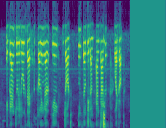

'a grand jury ruled that trolinger killed george in selfdefense and charges were dropped'

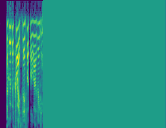

'a group of coeds play football while drinking'

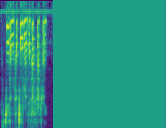

"students' achievement is satisfactory"

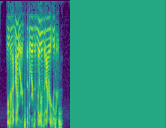

'these are not my words but the words of millions of irate users'

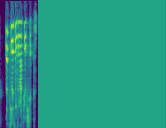

"let's listen to matthew shipp"

In [12]:
data.show_batch()

In [55]:
class DeepSpeech(nn.Module):
    def __init__(self, context=5, bs=64):
        super(DeepSpeech, self).__init__()
        self.bs = bs
        self.context = context
        self.h = None#(torch.zeros((2,5,2048)).cuda(),torch.zeros((2,5,2048)).cuda())#None
        self.flatten = nn.Flatten()#lambda x: torch.reshape(x,(-1,1,2432))
        self.relu = nn.ReLU()
        self.h1 = nn.Linear(128*2*self.context+128,2048)
        self.h2 = nn.Linear(2048,2048)
        self.h3 = nn.Linear(2048,2048)
        self.h4 = nn.LSTM(2048,2048,bidirectional=False,batch_first=True)
        #self.h4 = nn.RNN(2048,2048, nonlinearity="relu",bidirectional=True)
        self.h5 = nn.Linear(2048,29) #ct ∈ {a,b,c, . . . , z, space, apostrophe, blank}
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        x = nn.Flatten(-2,-1)(x)#torch.stack(x,dim=1)
        x = self.h1(x)#.clamp(min=0, max=20)
        x = self.relu(x)
        x = self.h2(x)#.clamp(min=0, max=20)
        x = self.relu(x)
        x = self.h3(x)#.clamp(min=0, max=20)
        x = self.relu(x)
        #if self.h is None:
        #    ;
        #elif self.h[0].shape[1]>x.size(0):
        #    self.h=tuple([each[:,:x.size(0),:] for each in model.h])
        #elif self.h[0].shape[1]<x.size(0):
        #    self.h=None#tuple([each.expand(-1,x.size(0),-1) for each in model.h])
        #x,h = self.h4(x, self.h)
        #self.h = to_detach(h, cpu=False)
        #x = x.view(-1,166,1,2048)
        #x = x.sum(dim=2)
        x = self.h5(x)#.clamp(min=0, max=20)
        x = self.softmax(x)
        return x

In [56]:
# def ctc_loss(input, target, bs=64, blank=28):
#     r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
#     i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
#     input = input.permute(1,0,2).detach().requires_grad_()
#     ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
#     t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
#     ret = ctc(input, target, input_lengths=i_length, target_lengths=t_length)#torch.tensor([100]*input.size(1)))
#     return ret

In [57]:
def ctc_loss(log_loss, target, bs=64, blank=28):
    r"""Loss function that makes CTC Loss easier to use especially for putting into a fastai Learner"""
    #i_length = torch.tensor([sum([1 for i in t.sum(1) if i != 0]) for t in input])
    def calculate_sizes(x):
        return x.shape[1] - (x.argmax(dim=2) == 28).sum(dim=1) - 1
    i_length = calculate_sizes(log_loss)
    log_loss = log_loss.permute(1,0,2).detach().requires_grad_()
    ctc = nn.CTCLoss(blank=blank, zero_infinity=True, reduction="sum")
    t_length = target.shape[-1]-(target==28).sum(dim=1)
    #t_length = torch.tensor([sum([1 for i in t if i != blank])for t in target])
    ret = ctc(log_loss, target, input_lengths=i_length, target_lengths=t_length)#torch.tensor([100]*input.size(1)))
    return ret

In [58]:
model = DeepSpeech(context=5, bs=32)

In [59]:
learn = Learner(data, model, loss_func=partial(ctc_loss,bs=32), opt_func=AdamW)

In [60]:
xb,yb = next(iter(learn.data.train_dl))

In [61]:
model(xb).shape

torch.Size([32, 166, 29])

In [62]:
xb.min()

tensor(-3.6198, device='cuda:0')

In [63]:
xb.max()

tensor(3.2402, device='cuda:0')

In [64]:
xb.mean()

tensor(0.0523, device='cuda:0')

In [65]:
xb.std()

tensor(0.9524, device='cuda:0')

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


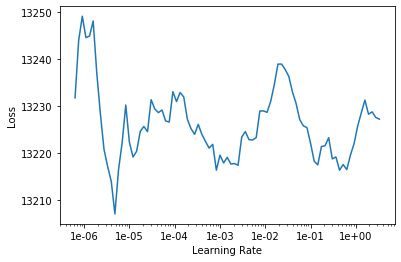

In [67]:
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,time
0,13231.723633,13053.788086,00:02
1,13233.024414,13052.852539,00:02
2,13220.959961,13051.217773,00:02
3,13219.992188,13049.540039,00:02
4,13218.200195,13048.072266,00:02
5,13220.165039,13046.933594,00:02
6,13217.859375,13046.133789,00:02
7,13217.376953,13045.701172,00:02
8,13215.331055,13045.529297,00:02
9,13215.720703,13045.502930,00:02


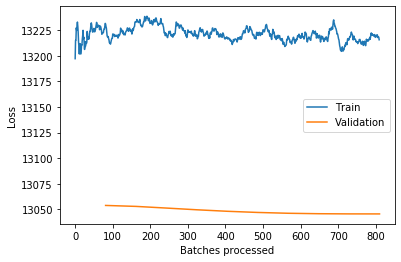

In [69]:
learn.recorder.plot_losses()

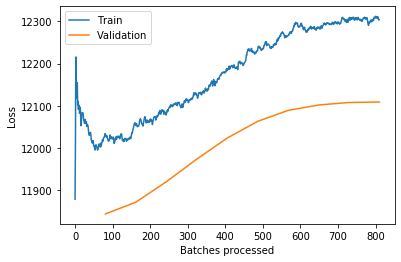

In [39]:
learn.recorder.plot_losses()

In [70]:
preds,targs = learn.get_preds()

In [71]:
phrase = 0
print("".join([learn.data.itoc[i] for i in preds.argmax(dim=2)[phrase]]))
print("".join([learn.data.itoc[i]for i in targs[phrase]]))

yayzvhz'vyznhrrhryyrhnhhrrhhhzzhyyanyyy'yyhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh
stop fooling damn you


In [72]:
preds.shape

torch.Size([652, 166, 29])

In [73]:
preds.argmax(dim=2)

tensor([[24,  0, 24,  ...,  7,  7,  7],
        [24, 24, 24,  ...,  7,  7,  7],
        [24,  0, 24,  ...,  7,  7,  7],
        ...,
        [24,  0, 24,  ...,  7,  7,  7],
        [24, 24,  7,  ...,  7,  7,  7],
        [24, 24, 24,  ...,  7,  7,  7]])

In [32]:
preds[0].shape

torch.Size([166, 29])

In [54]:
preds[0][-1]

tensor([0.0352, 0.0331, 0.0348, 0.0352, 0.0349, 0.0335, 0.0353, 0.0339, 0.0349,
        0.0345, 0.0350, 0.0335, 0.0344, 0.0350, 0.0338, 0.0341, 0.0336, 0.0343,
        0.0355, 0.0352, 0.0342, 0.0342, 0.0347, 0.0345, 0.0345, 0.0349, 0.0344,
        0.0347, 0.0342])

In [78]:
preds[0][-1][23]

tensor(-3.3375)

In [74]:
preds[0][-1].argmax()

tensor(23)